## NLP: Using Doc2Vec to Predict Review Usefulness

In [1]:
import os
import codecs
import json
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)

%matplotlib inline
import matplotlib.pyplot as plt

data_directory = os.path.join('C:/Users/andre/Documents/yelp_dataset_challenge_round9')
intermediate_directory = os.path.join(data_directory, 'intermediate')

In [2]:
df = pd.read_csv(os.path.join(intermediate_directory, 'useful.csv'))
luseful = np.log(df['useful'] + 1)

In [3]:
# Gensim's Doc2Vec class creates vector representations for entire documents
# The input object is an iterator of LineSentence objects
# The default dm=1 refers to the distributed memory algorithm
# The algorithm runs through sentences twice: (1) build the vocab, 
# (2) learn a vector representation for each word and for each label (sentence)
# Better results can be achieved by iterating over the data several times

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence

doc2vec_filepath = os.path.join(intermediate_directory, 'doc2vec_model')
doc2vec = Doc2Vec.load(doc2vec_filepath)

In [4]:
print(u'{:,} terms in the word2vec vocabulary.'.format(len(doc2vec.wv.vocab)))

6,130 terms in the word2vec vocabulary.


In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, ShuffleSplit
from sklearn.metrics import mean_squared_error, make_scorer
from collections import defaultdict
from tabulate import tabulate

In [6]:
def cv_rmse(model, X, y, cv=5, scoring='neg_mean_squared_error'):
    
    """ Compute an overall RMSE across all folds of cross validation"""
    
    return np.sqrt(np.mean(np.multiply(cross_val_score(
    model, X, y, cv=cv, scoring='neg_mean_squared_error'), -1)))
    
def RMSE(y_true, y_pred):
    
    """ Root Mean Squared Error"""
    
    return np.sqrt(np.mean((y_true - y_pred)**2))

def RMSLE(y_true, y_pred):
    
    """ Root Mean Squared Logarithmic Error"""
    
    return np.sqrt(np.mean(((np.log(y_true + 1) - np.log(y_pred + 1))**2)))

In [7]:
lr_d2v = Pipeline([("lr", LinearRegression())])
ridge_d2v = Pipeline([("ridge", Ridge(alpha=1))])
gbr_d2v = Pipeline([("gbr", GradientBoostingRegressor(n_estimators=100))])
rfr_d2v = Pipeline([("rfr", RandomForestRegressor(n_estimators=100))])
xgb_d2v = Pipeline([("xgb", XGBRegressor(n_estimators=100))])

In [8]:
d2v_models = [("lr_d2v", lr_d2v), ("ridge_d2v", ridge_d2v), ("gbr_d2v", gbr_d2v), 
              ("rfr_d2v", rfr_d2v), ("xgb_d2v", xgb_d2v)]

d2v_rmse = [(name, cv_rmse(model, np.array(doc2vec.docvecs), luseful, cv=5)) 
              for name, model in d2v_models]

In [9]:
print (tabulate(sorted(d2v_rmse, key=lambda x:x[1]), floatfmt=".4f", headers=("model", "RMSE_5cv")))

model        RMSE_5cv
---------  ----------
xgb_d2v        0.5850
gbr_d2v        0.5853
rfr_d2v        0.5900
ridge_d2v      0.5974
lr_d2v         0.5974


### Predicting Review Usefulness Based on the Amount of Training Data


In [10]:
def benchmark(model, X, y, n):
    ss = ShuffleSplit(n_splits=5, test_size = 1 - n, random_state=0)
    scores = []
    for train, test in ss.split(X,y):
        scores.append(RMSE(y[test], model.fit(X[train],y[train]).predict(X[test])))
    return np.mean(scores)

In [11]:
train_sizes = [0.3, 0.5, 0.7]
table = []

for name, model in d2v_models:
    for n in train_sizes:
        table.append({'model': name, 
                      'RMSE': benchmark(model, np.array(doc2vec.docvecs), luseful, n),
                      'train_size': n})
df = pd.DataFrame(table)

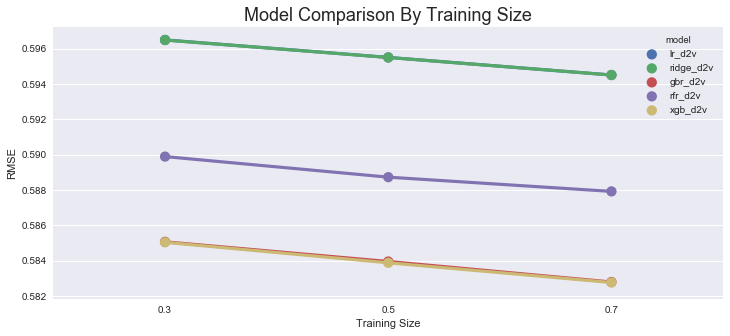

In [12]:
plt.figure(figsize=(12,5))
fig = sns.pointplot(x='train_size', y='RMSE', hue='model',
                   data=df)
sns.set_context('notebook', font_scale=1.5)
fig.set(ylabel='RMSE')
fig.set(xlabel='Training Size')
fig.set(title='Model Comparison By Training Size')
plt.show()

In [32]:
pd.pivot_table(df, values='RMSE', index='model', columns='train_size').sort_values(by=0.3)

train_size,0.3,0.5,0.7
model,,,
xgb_d2v,0.585045,0.583885,0.582770
gbr_d2v,0.585071,0.583958,0.582798
rfr_d2v,0.589895,0.588732,0.587925
ridge_d2v,0.596490,0.595505,0.594511
lr_d2v,0.596498,0.595508,0.594512


### Tuning Parameters for XGBoost Regressor

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(
    np.array(doc2vec.docvecs), luseful, test_size=0.3, random_state=0)

In [8]:
def modelfit(alg, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    """ Determine the optimal number of trees for a given learning rate """
    if useTrainCV:
        xgb_params = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, y_train)
        cvresult = xgb.cv(xgb_params, 
                          xgtrain, 
                          num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          metrics='rmse', 
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    # Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='rmse')
    print("Model Report")
    print("Best iteration: {}".format(cvresult.shape[0]))
    print("RMSE (Train): {:.4f}".format(RMSE(y_train, alg.predict(X_train))))
    print("RMSE (Test): {:.4f}".format(RMSE(y_test, alg.predict(X_test))))
    predict_test = alg.predict(X_test)

In [9]:
# Given a learning rate of 0.1, find the optimal number of trees
modelfit(XGBRegressor(learning_rate=0.1, 
                    n_estimators=1000, 
                    max_depth=3,
                    min_child_weight=1,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    reg_lambda=1,
                    n_jobs=4,  
                    random_state=0))

Model Report
Best iteration: 232
RMSE (Train): 0.5666345435938157
RMSE (Test): 0.5832624708048219


In [10]:
# Set the n_estimators equal to the optimal number of trees
xgb1 = XGBRegressor(learning_rate=0.1, 
                    n_estimators=232, 
                    max_depth=3,
                    min_child_weight=1,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    reg_lambda=1,
                    n_jobs=4,  
                    random_state=0)

In [11]:
def gs_results(gsearch):
    return pd.DataFrame(gsearch.cv_results_)[['params',
                                              'rank_test_score',
                                              'mean_test_score',
                                              'std_test_score',
                                              'mean_train_score',
                                              'std_train_score']].sort_values('rank_test_score')

In [12]:
param_test1 = {'max_depth': range(3, 8, 2),
               'min_child_weight': range(1, 6, 2)}
gsearch1 = GridSearchCV(xgb1, param_grid=param_test1, scoring='neg_mean_squared_error', n_jobs=4, cv=3)
gsearch1.fit(X_train, y_train)
gs_results(gsearch1)

,params,rank_test_score,mean_test_score,std_test_score,mean_train_score,std_train_score
1,"{'max_depth': 3, 'min_child_weight': 3}",1,-0.342588,0.002311,-0.313586,0.001357
2,"{'max_depth': 3, 'min_child_weight': 5}",2,-0.342925,0.002053,-0.313474,0.001162
0,"{'max_depth': 3, 'min_child_weight': 1}",3,-0.342933,0.002128,-0.313508,0.001311
3,"{'max_depth': 5, 'min_child_weight': 1}",4,-0.345487,0.002492,-0.254096,0.001066
5,"{'max_depth': 5, 'min_child_weight': 5}",5,-0.345644,0.001886,-0.254624,0.001440
4,"{'max_depth': 5, 'min_child_weight': 3}",6,-0.345711,0.002286,-0.254244,0.001462
8,"{'max_depth': 7, 'min_child_weight': 5}",7,-0.351985,0.002520,-0.149760,0.000576
6,"{'max_depth': 7, 'min_child_weight': 1}",8,-0.352196,0.003331,-0.148397,0.000776
7,"{'max_depth': 7, 'min_child_weight': 3}",9,-0.352680,0.002754,-0.147662,0.000826


In [13]:
param_test2 = {'subsample': [i/10 for i in range(6,9)],
               'colsample_bytree': [i/10 for i in range(6,9)]}
gsearch2 = GridSearchCV(xgb1, param_grid=param_test2, scoring='neg_mean_squared_error', n_jobs=4, cv=3)
gsearch2.fit(X_train, y_train)
gs_results(gsearch2)

,params,rank_test_score,mean_test_score,std_test_score,mean_train_score,std_train_score
2,"{'colsample_bytree': 0.6, 'subsample': 0.8}",1,-0.342546,0.002288,-0.314424,0.001265
5,"{'colsample_bytree': 0.7, 'subsample': 0.8}",2,-0.342879,0.002367,-0.313787,0.000951
8,"{'colsample_bytree': 0.8, 'subsample': 0.8}",3,-0.342933,0.002128,-0.313508,0.001311
6,"{'colsample_bytree': 0.8, 'subsample': 0.6}",4,-0.343059,0.002438,-0.314483,0.001183
4,"{'colsample_bytree': 0.7, 'subsample': 0.7}",5,-0.343147,0.002110,-0.314204,0.001107
7,"{'colsample_bytree': 0.8, 'subsample': 0.7}",6,-0.343159,0.002534,-0.313944,0.001186
0,"{'colsample_bytree': 0.6, 'subsample': 0.6}",7,-0.343296,0.002376,-0.315354,0.000914
1,"{'colsample_bytree': 0.6, 'subsample': 0.7}",8,-0.343306,0.002063,-0.314828,0.000821
3,"{'colsample_bytree': 0.7, 'subsample': 0.6}",9,-0.343488,0.002483,-0.314886,0.001051


In [14]:
param_test3 = {'reg_lambda': [0.001, 0.01, 0.1, 1, 10]}
gsearch3 = GridSearchCV(xgb1, param_grid=param_test3, scoring='neg_mean_squared_error', n_jobs=4, cv=3)
gsearch3.fit(X_train, y_train)
gs_results(gsearch3)

,params,rank_test_score,mean_test_score,std_test_score,mean_train_score,std_train_score
4,{'reg_lambda': 10},1,-0.342213,0.002156,-0.314823,0.001153
1,{'reg_lambda': 0.01},2,-0.342534,0.002408,-0.313152,0.001166
0,{'reg_lambda': 0.001},3,-0.342597,0.002290,-0.313209,0.001180
2,{'reg_lambda': 0.1},4,-0.342919,0.002101,-0.313269,0.001414
3,{'reg_lambda': 1},5,-0.342933,0.002128,-0.313508,0.001311


In [9]:
xgb2 = XGBRegressor(learning_rate=0.1, 
                    n_estimators=232, 
                    max_depth=3,
                    min_child_weight=3,
                    subsample=0.8,
                    colsample_bytree=0.6,
                    reg_lambda=10,
                    n_jobs=4,  
                    random_state=0)
xgb2.fit(X_train, y_train, eval_metric='rmse')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=3, missing=None, n_estimators=232,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=10, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [33]:
modelfit(xgb2)

Model Report
Best iteration: 180
RMSE (Train): 0.5707639287714431
RMSE (Test): 0.5829574978635869


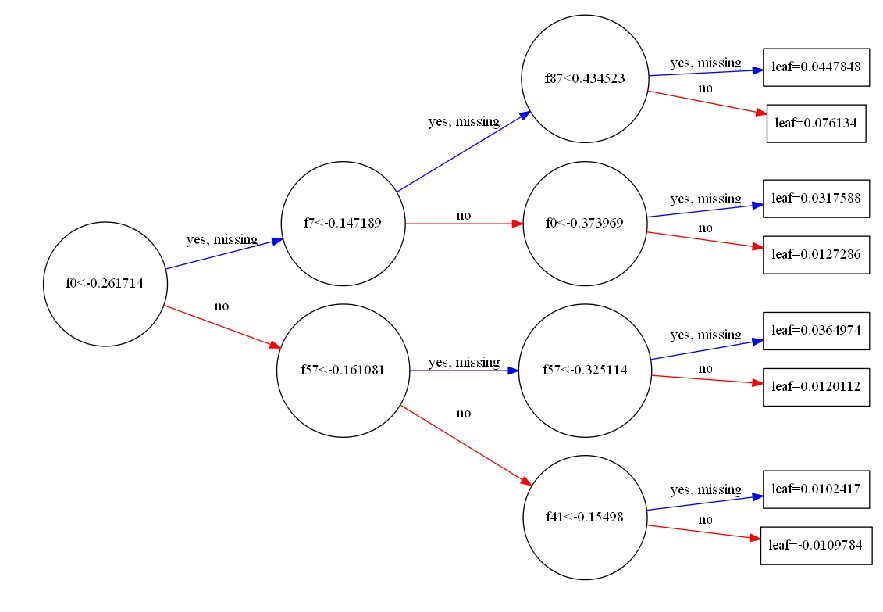

In [20]:
ax = xgb.plot_tree(xgb2, rankdir='LR')
fig = ax.figure 
fig.set_size_inches(15,12)
plt.show()

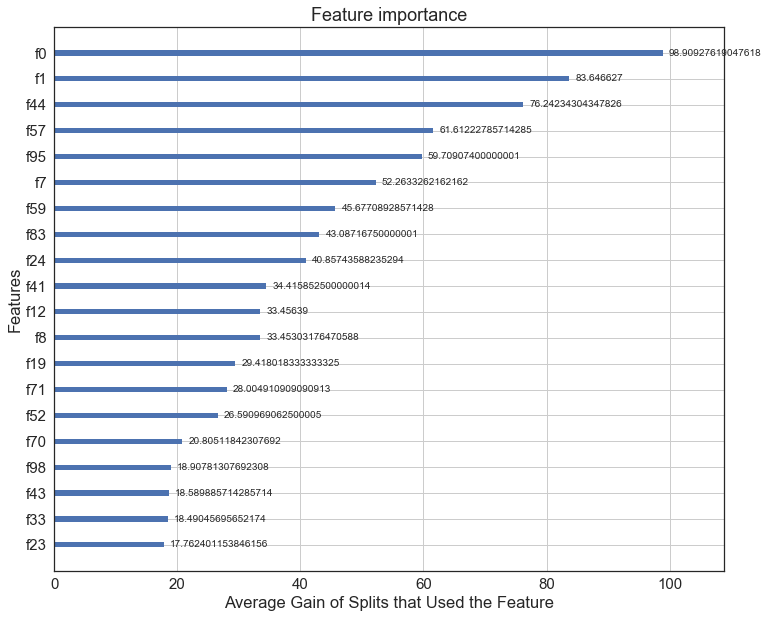

In [30]:
ax = xgb.plot_importance(xgb2, 
                         importance_type='gain', 
                         max_num_features=20,
                         xlabel='Average Gain of Splits that Used the Feature')
fig = ax.figure 
fig.set_size_inches(12,10)
plt.show()

In [34]:
modelfit(XGBRegressor(learning_rate=0.01, 
                    n_estimators=2000, 
                    max_depth=3,
                    min_child_weight=3,
                    subsample=0.8,
                    colsample_bytree=0.6,
                    reg_lambda=10,
                    n_jobs=4,  
                    random_state=0))

Model Report
Best iteration: 1847
RMSE (Train): 0.5698224642673488
RMSE (Test): 0.5821288563296201
